# Assignment 2

### 1. Load Data

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from tqdm import tqdm
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Set TensorFlow logging level to suppress unnecessary output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# Helper function: Load embeddings from TFRecord files
def load_embedding(embedding_path):
    raw_dataset = tf.data.TFRecordDataset([embedding_path])
    for raw_record in raw_dataset.take(1):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        embedding_feature = example.features.feature['embedding']
        embedding_values = embedding_feature.float_list.value
    embedding = torch.tensor(embedding_values)
    if torch.isnan(embedding).any() or torch.isinf(embedding).any():
        raise ValueError(f"NaN or Inf found in embedding: {embedding_path}")
    return embedding

# Custom dataset class for MIMIC chest X-ray embeddings
class MIMIC_Embed_Dataset(Dataset):
    pathologies = [
        "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion",
        "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax",
        "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices"
    ]

    def __init__(self, embedpath, csvpath, metacsvpath, views=["PA"], mode="train", seed=42, split_ratio=[0.5, 0.3, 0.2], unique_patients=True):
        super().__init__()
        np.random.seed(seed)  # Set seed for reproducibility
        self.pathologies = sorted(self.pathologies)
        self.mode = mode
        self.embedpath = embedpath
        self.csv = pd.read_csv(csvpath)
        self.metacsv = pd.read_csv(metacsvpath)
        self.split_ratio = split_ratio

        # Merge CSV data
        self.csv = self.csv.set_index(["subject_id", "study_id"])
        self.metacsv = self.metacsv.set_index(["subject_id", "study_id"])
        self.csv = self.csv.join(self.metacsv).reset_index()

        self.csv["view"] = self.csv["ViewPosition"]
        self.limit_to_selected_views(views)

        if unique_patients:
            self.csv = self.csv.groupby("subject_id").first().reset_index()

        # Split dataset into train, validation, and test sets
        n_row = self.csv.shape[0]
        if self.mode == "train":
            self.csv = self.csv[:int(n_row * self.split_ratio[0])]
        elif self.mode == "valid":
            self.csv = self.csv[int(n_row * self.split_ratio[0]):int(n_row * (self.split_ratio[0] + self.split_ratio[1]))]
        elif self.mode == "test":
            self.csv = self.csv[int(n_row * (self.split_ratio[0] + self.split_ratio[1])):]
        else:
            raise ValueError(f"mode must be one of [train, valid, test], got {self.mode}")

        # Process labels
        healthy = self.csv["No Finding"] == 1
        labels = []
        for pathology in self.pathologies:
            if pathology in self.csv.columns:
                self.csv.loc[healthy, pathology] = 0
                mask = self.csv[pathology]
            labels.append(mask.values)
        self.labels = np.asarray(labels).T.astype(np.float32)
        self.labels[np.isnan(self.labels)] = 0  # Replace all NaN values with 0
        self.labels = np.where((self.labels != 0) & (self.labels != 1), 0, self.labels)

        self.csv = self.csv.reset_index(drop=True)
        self.pathologies = list(np.char.replace(self.pathologies, "Pleural Effusion", "Effusion"))
        self.csv["offset_day_int"] = self.csv["StudyDate"]
        self.csv["patientid"] = self.csv["subject_id"].astype(str)

    def limit_to_selected_views(self, views):
        # Limit dataset to specified views
        if not isinstance(views, list):
            views = [views]
        if '*' in views:
            views = ["*"]
        self.views = views
        self.csv["view"] = self.csv["view"].fillna("UNKNOWN")
        if "*" not in views:
            self.csv = self.csv[self.csv["view"].isin(self.views)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Retrieve a single sample from the dataset
        sample = {}
        sample["idx"] = idx
        sample["lab"] = self.labels[idx]
        subjectid = str(self.csv.iloc[idx]["subject_id"])
        studyid = str(self.csv.iloc[idx]["study_id"])
        dicom_id = str(self.csv.iloc[idx]["dicom_id"])
        embed_file = os.path.join(self.embedpath, f"p{subjectid[:2]}", f"p{subjectid}", f"s{studyid}", f"{dicom_id}.tfrecord")
        sample["embedding"] = load_embedding(embed_file)
        return sample

# Function to initialize datasets with given paths, seed, and split ratio
def initialize_mimic_datasets(embedpath, csvpath, metacsvpath, seed=42, split_ratio=[0.5, 0.3, 0.2]):
    """
    Initialize MIMIC chest X-ray datasets with specified paths, seed, and split ratio.
    
    Args:
        embedpath (str): Path to the embedding files
        csvpath (str): Path to the CheXpert CSV file
        metacsvpath (str): Path to the metadata CSV file
        seed (int): Random seed for reproducibility (default: 42)
        split_ratio (list): Train, validation, test split ratio (default: [0.5, 0.3, 0.2])
    
    Returns:
        tuple: (train_dataset, val_dataset, test_dataset)
    """
    train_dataset = MIMIC_Embed_Dataset(
        embedpath=embedpath,
        csvpath=csvpath,
        metacsvpath=metacsvpath,
        mode="train",
        seed=seed,
        split_ratio=split_ratio
    )
    val_dataset = MIMIC_Embed_Dataset(
        embedpath=embedpath,
        csvpath=csvpath,
        metacsvpath=metacsvpath,
        mode="valid",
        seed=seed,
        split_ratio=split_ratio
    )
    test_dataset = MIMIC_Embed_Dataset(
        embedpath=embedpath,
        csvpath=csvpath,
        metacsvpath=metacsvpath,
        mode="test",
        seed=seed,
        split_ratio=split_ratio
    )
    return train_dataset, val_dataset, test_dataset

# Data paths
embedpath = "generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0/files"
csvpath = "data/mimic-cxr-2.0.0-chexpert.csv"
metacsvpath = "data/mimic-cxr-2.0.0-metadata.csv"

train_dataset, val_dataset, test_dataset = initialize_mimic_datasets(
    embedpath=embedpath,
    csvpath=csvpath,
    metacsvpath=metacsvpath,
    seed=42,
    split_ratio=[0.5, 0.3, 0.2]
)

=== Dataset Sizes ===
Train dataset size: 22814
Validation dataset size: 13688
Test dataset size: 9126
Total size: 45628
Split ratio: Train 0.500, Validation 0.300, Test 0.200

=== Label Distribution ===

Train Dataset:
Number of samples: 22814
Number of pathologies: 13
                            Proportion of 0s  Proportion of 1s
Atelectasis                            0.912             0.088
Cardiomegaly                           0.917             0.083
Consolidation                          0.982             0.018
Edema                                  0.975             0.025
Enlarged Cardiomediastinum             0.984             0.016
Fracture                               0.978             0.022
Lung Lesion                            0.971             0.029
Lung Opacity                           0.882             0.118
Effusion                               0.919             0.081
Pleural Other                          0.989             0.011
Pneumonia                           

/var/folders/2r/fz6dh1yd3sd_tkf6dcfmj10w0000gn/T/ipykernel_56373/3996613693.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=["Train", "Validation", "Test"], y=sizes, palette=colors)


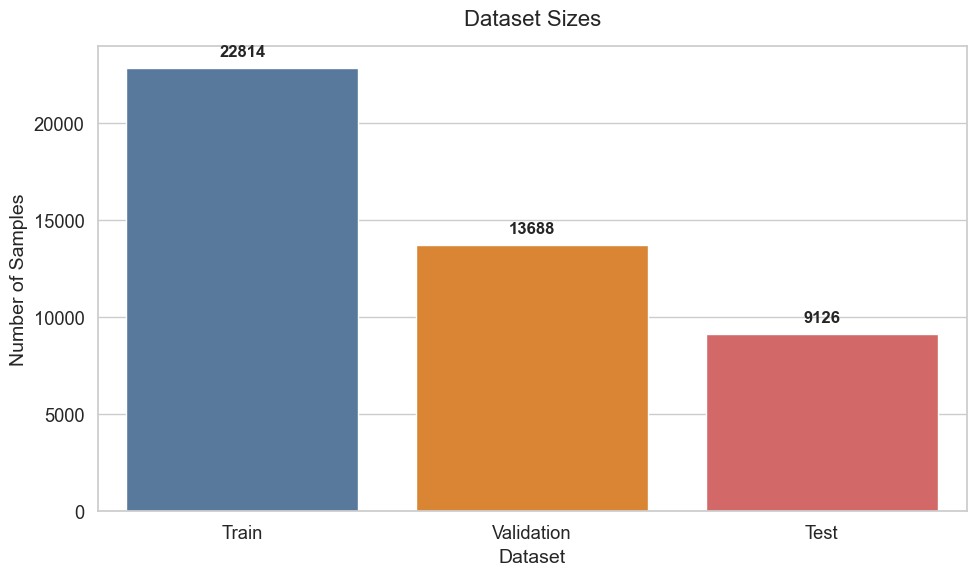

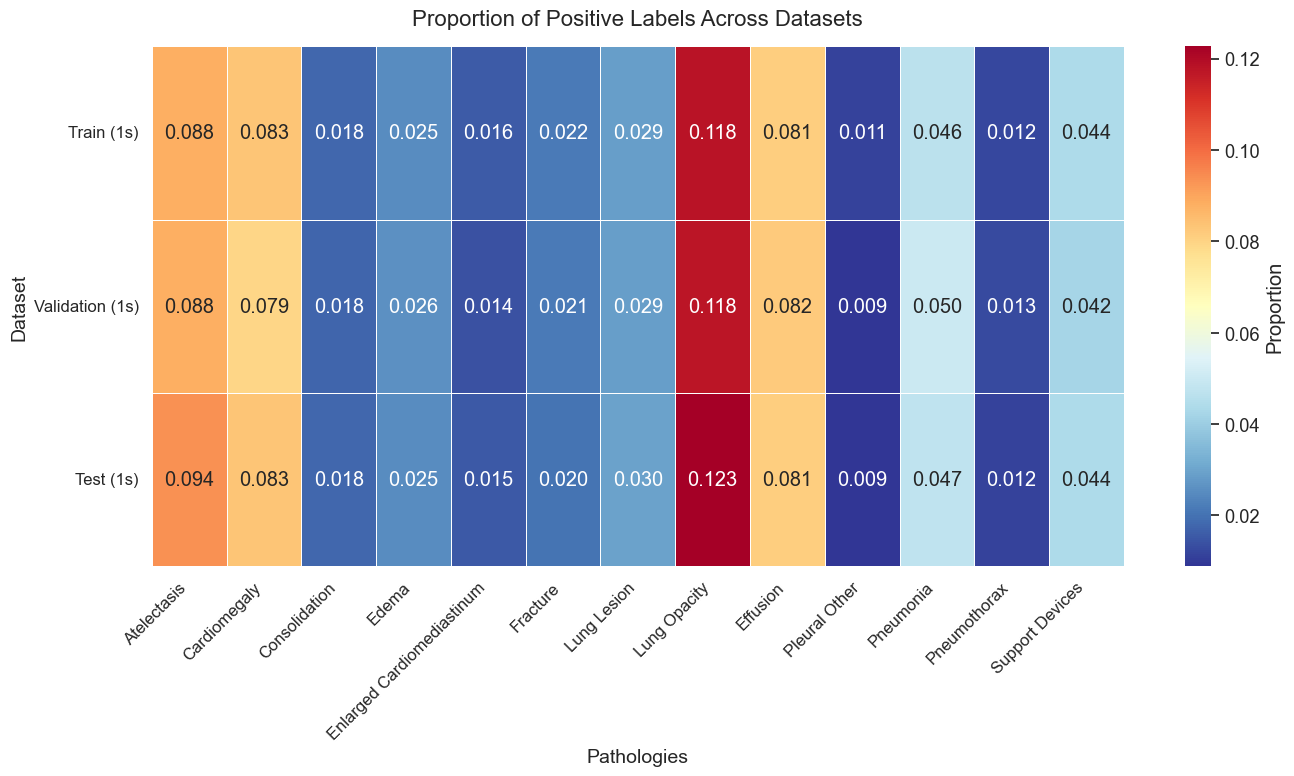

In [2]:
# Function to perform data quality checks with improved visualizations
def check_dataset_quality(train_dataset, val_dataset, test_dataset):
    """
    Perform quality checks on the datasets, including size and label distribution.
    
    Args:
        train_dataset: Training dataset
        val_dataset: Validation dataset
        test_dataset: Test dataset
    """
    datasets = {
        "Train": train_dataset,
        "Validation": val_dataset,
        "Test": test_dataset
    }
    
    # 1. Check dataset sizes
    print("=== Dataset Sizes ===")
    total_size = 0
    for name, dataset in datasets.items():
        size = len(dataset)
        total_size += size
        print(f"{name} dataset size: {size}")
    print(f"Total size: {total_size}")
    print(f"Split ratio: Train {len(train_dataset)/total_size:.3f}, "
          f"Validation {len(val_dataset)/total_size:.3f}, "
          f"Test {len(test_dataset)/total_size:.3f}\n")

    # 2. Check label distribution
    print("=== Label Distribution ===")
    for name, dataset in datasets.items():
        labels = dataset.labels  # Shape: (n_samples, n_pathologies)
        print(f"\n{name} Dataset:")
        print(f"Number of samples: {labels.shape[0]}")
        print(f"Number of pathologies: {labels.shape[1]}")
        
        # Calculate proportion of 0s and 1s for each pathology
        proportions = pd.DataFrame(index=dataset.pathologies)
        proportions["Proportion of 0s"] = np.mean(labels == 0, axis=0)
        proportions["Proportion of 1s"] = np.mean(labels == 1, axis=0)
        print(proportions.round(3))

    # 3. Enhanced Visualizations
    # Set a consistent style
    plt.style.use('seaborn-v0_8-whitegrid')  # Clean and modern style
    sns.set_context("notebook", font_scale=1.2)  # Increase font size for readability

    # Bar plot of dataset sizes
    plt.figure(figsize=(10, 6))
    sizes = [len(train_dataset), len(val_dataset), len(test_dataset)]
    colors = ['#4C78A8', '#F58518', '#E45756']  # Custom color palette
    bars = sns.barplot(x=["Train", "Validation", "Test"], y=sizes, palette=colors)
    
    # Add annotations on top of bars
    for i, bar in enumerate(bars.patches):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.02*max(sizes), 
                f'{int(height)}', ha='center', va='bottom', fontsize=12, weight='bold')
    
    plt.title("Dataset Sizes", fontsize=16, pad=15)
    plt.ylabel("Number of Samples", fontsize=14)
    plt.xlabel("Dataset", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Combined heatmap for all datasets
    plt.figure(figsize=(14, 8))
    combined_proportions = pd.DataFrame(index=train_dataset.pathologies)
    for name, dataset in datasets.items():
        labels = dataset.labels
        combined_proportions[f"{name} (1s)"] = np.mean(labels == 1, axis=0)
    
    # Create heatmap with a diverging color palette
    sns.heatmap(combined_proportions.T, annot=True, cmap="RdYlBu_r", fmt=".3f", 
                cbar_kws={'label': 'Proportion'}, linewidths=0.5, square=False)
    
    plt.title("Proportion of Positive Labels Across Datasets", fontsize=16, pad=15)
    plt.xlabel("Pathologies", fontsize=14)
    plt.ylabel("Dataset", fontsize=14)
    plt.xticks(rotation=45, ha="right", fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()

# Example usage with the initialized datasets
check_dataset_quality(train_dataset, val_dataset, test_dataset)

### 2. Data Preprocessing

In [3]:
# 计算正负样本数量并设置 pos_weight
labels = train_dataset.labels
pos_counts = np.sum(labels == 1, axis=0)
neg_counts = np.sum(labels == 0, axis=0)
pos_weight = torch.tensor([neg / pos if pos > 0 else 1 for pos, neg in zip(pos_counts, neg_counts)]).float()

# 使用 WeightedRandomSampler 处理类别不平衡
weights = np.where(np.nansum(labels, axis=1) > 0, 10.0, 1.0)  # 正样本权重设为 10.0，可调整
sampler = WeightedRandomSampler(weights, len(weights))

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=0)  # num_workers=0 避免多进程问题
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


### 3. Model Training

In [4]:

# 定义优化后的全连接神经网络
class OptimizedFCNN(nn.Module):
    def __init__(self, input_dim=1376, dropout_prob=0.3):
        super(OptimizedFCNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(dropout_prob)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(dropout_prob)
        
        self.fc4 = nn.Linear(128, 13)
        
        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        
        x = self.fc4(x)
        return x

# 自定义损失函数
def custom_bce_loss(outputs, targets, pos_weight=None):
    # 创建掩码，标记非 nan 的标签
    mask = ~torch.isnan(targets)
    # 将 targets 中的 nan 替换为 0，但用掩码忽略它们
    targets_filled = torch.where(torch.isnan(targets), torch.zeros_like(targets), targets)
    # 计算逐元素的损失
    loss_fn = nn.BCEWithLogitsLoss(reduction='none', pos_weight=pos_weight)
    loss = loss_fn(outputs, targets_filled)
    # 只保留有效标签的损失
    loss = loss * mask
    # 计算平均损失
    valid_mask_sum = mask.sum()
    if valid_mask_sum > 0:
        final_loss = loss.sum() / valid_mask_sum
        return final_loss
    else:
        print("警告：批次中所有标签均为 NaN，返回 0 损失")
        return torch.tensor(0.0, requires_grad=True).to(outputs.device)

# 训练设置
device = torch.device(
    "mps" if torch.backends.mps.is_available() else 
    "cuda" if torch.cuda.is_available() else 
    "cpu"
)
print(f"Using device: {device}")
model = OptimizedFCNN(input_dim=1376, dropout_prob=0.2).to(device)
optimizer = AdamW(model.parameters(), lr=5e-6, weight_decay=5e-6)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)
pos_weight = pos_weight.to(device)



Using device: mps


In [5]:
print("pos_weight:", pos_weight)
if torch.isinf(pos_weight).any() or torch.isnan(pos_weight).any():
    raise ValueError("pos_weight contains inf or nan")

pos_weight: tensor([10.3446, 11.0264, 55.0541, 38.8846, 61.6758, 44.9960, 33.6717,  7.4684,
        11.3319, 86.4100, 20.5226, 80.4786, 21.8140], device='mps:0')


In [6]:
# 训练循环
num_epochs = 50
best_val_loss = float('inf')
patience = 2
patience_counter = 0
best_model_path = 'best_model.pth'

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]'):
        embeddings = batch['embedding'].to(device)
        labels = batch['lab'].to(device)
        outputs = model(embeddings)
        loss = custom_bce_loss(outputs, labels, pos_weight=pos_weight)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # 验证
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]'):
            embeddings = batch['embedding'].to(device)
            labels = batch['lab'].to(device)
            outputs = model(embeddings)
            loss = custom_bce_loss(outputs, labels, pos_weight=pos_weight)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print(f'Saved best model with Val Loss: {best_val_loss:.4f}')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping triggered')
            break

Epoch 1/50 [Val]: 100%|██████████| 428/428 [01:43<00:00,  4.15it/s]


Epoch 1/50, Train Loss: 2.7959, Val Loss: 1.2346
Saved best model with Val Loss: 1.2346


Epoch 2/50 [Val]: 100%|██████████| 428/428 [01:34<00:00,  4.52it/s]


Epoch 2/50, Train Loss: 2.4482, Val Loss: 1.1579
Saved best model with Val Loss: 1.1579


Epoch 3/50 [Val]: 100%|██████████| 428/428 [01:26<00:00,  4.95it/s]


Epoch 3/50, Train Loss: 2.2271, Val Loss: 1.1169
Saved best model with Val Loss: 1.1169


Epoch 4/50 [Val]: 100%|██████████| 428/428 [01:29<00:00,  4.80it/s]


Epoch 4/50, Train Loss: 2.0935, Val Loss: 1.0868
Saved best model with Val Loss: 1.0868


Epoch 5/50 [Val]: 100%|██████████| 428/428 [02:01<00:00,  3.52it/s]


Epoch 5/50, Train Loss: 2.0172, Val Loss: 1.0685
Saved best model with Val Loss: 1.0685


Epoch 6/50 [Val]: 100%|██████████| 428/428 [01:57<00:00,  3.64it/s]


Epoch 6/50, Train Loss: 1.9446, Val Loss: 1.0527
Saved best model with Val Loss: 1.0527


Epoch 7/50 [Val]: 100%|██████████| 428/428 [01:41<00:00,  4.22it/s]


Epoch 7/50, Train Loss: 1.8937, Val Loss: 1.0503
Saved best model with Val Loss: 1.0503


Epoch 8/50 [Val]: 100%|██████████| 428/428 [01:32<00:00,  4.62it/s]


Epoch 8/50, Train Loss: 1.8249, Val Loss: 1.0490
Saved best model with Val Loss: 1.0490


Epoch 9/50 [Val]: 100%|██████████| 428/428 [01:24<00:00,  5.07it/s]


Epoch 9/50, Train Loss: 1.8062, Val Loss: 1.0478
Saved best model with Val Loss: 1.0478


Epoch 10/50 [Val]: 100%|██████████| 428/428 [01:23<00:00,  5.10it/s]


Epoch 10/50, Train Loss: 1.7610, Val Loss: 1.0478
Saved best model with Val Loss: 1.0478


Epoch 11/50 [Val]: 100%|██████████| 428/428 [02:29<00:00,  2.87it/s]


Epoch 11/50, Train Loss: 1.7341, Val Loss: 1.0498


Epoch 12/50 [Val]: 100%|██████████| 428/428 [02:39<00:00,  2.69it/s]


Epoch 12/50, Train Loss: 1.7115, Val Loss: 1.0471
Saved best model with Val Loss: 1.0471


Epoch 13/50 [Val]: 100%|██████████| 428/428 [01:39<00:00,  4.29it/s]


Epoch 13/50, Train Loss: 1.6990, Val Loss: 1.0423
Saved best model with Val Loss: 1.0423


Epoch 14/50 [Val]: 100%|██████████| 428/428 [01:38<00:00,  4.36it/s]


Epoch 14/50, Train Loss: 1.6734, Val Loss: 1.0390
Saved best model with Val Loss: 1.0390


Epoch 15/50 [Val]: 100%|██████████| 428/428 [01:39<00:00,  4.30it/s]


Epoch 15/50, Train Loss: 1.6482, Val Loss: 1.0535


Epoch 16/50 [Val]: 100%|██████████| 428/428 [01:29<00:00,  4.77it/s]

Epoch 16/50, Train Loss: 1.6575, Val Loss: 1.0514
Early stopping triggered


### 4. Model Evaluation

/var/folders/2r/fz6dh1yd3sd_tkf6dcfmj10w0000gn/T/ipykernel_56373/1626349481.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_p


Confusion Matrices for Each Pathology (excluding NaN):

Atelectasis:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[6771 1500]
 [ 280  575]]

Cardiomegaly:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[6894 1471]
 [ 193  568]]

Consolidation:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[7583 1377]
 [  54  112]]

Edema:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[8012  885]
 [  47  182]]

Enlarged Cardiomediastinum:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[7133 1854]
 [  74   65]]

Fracture:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[5044 3898]
 [  75  109]]

Lung Lesion:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[7209 1646]
 [ 119  152]]

Lung Opacity:
[[True Negative, False Positive]
 [False Negative, True Positive]]
[[6154 1852]
 [ 382  738]]

Effusion:
[[True Negative, False Positive]
 [False Negative, True Pos

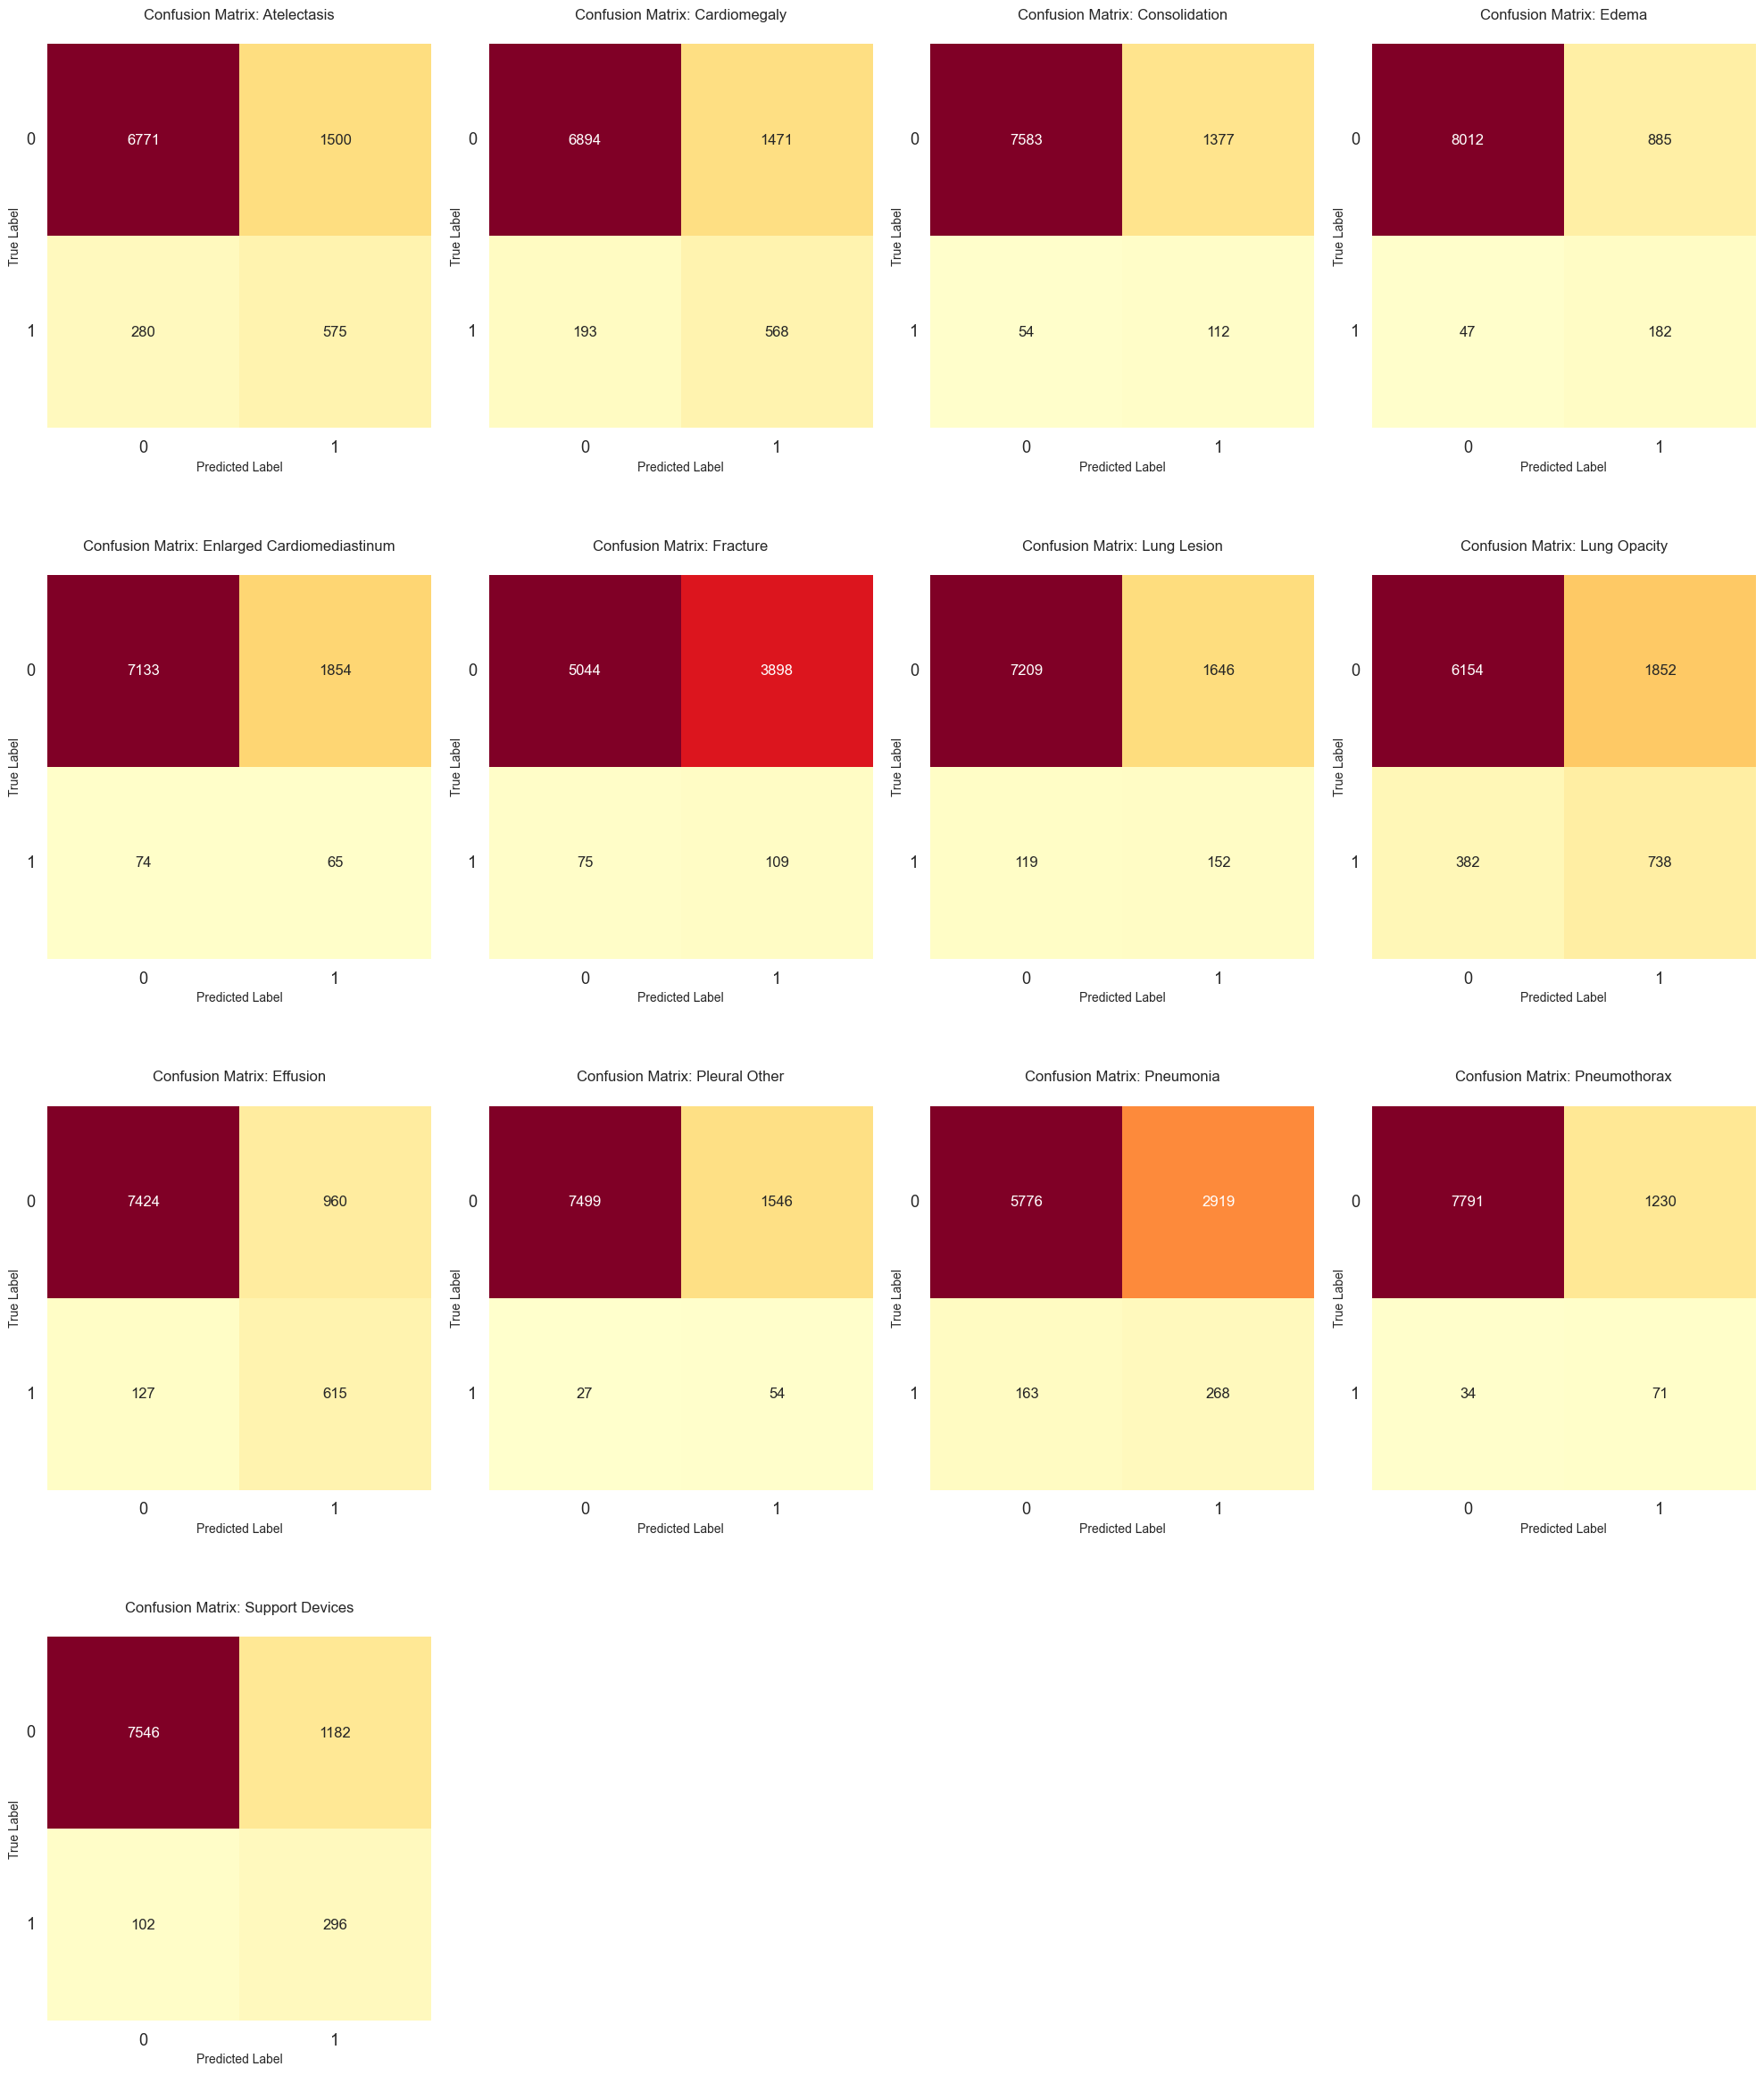

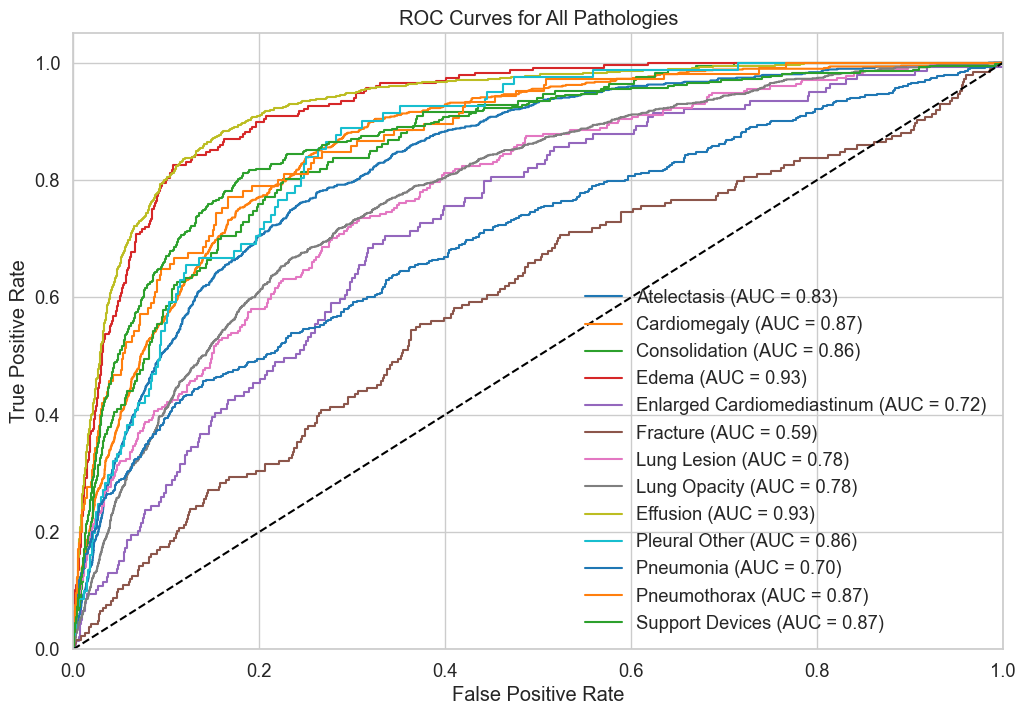

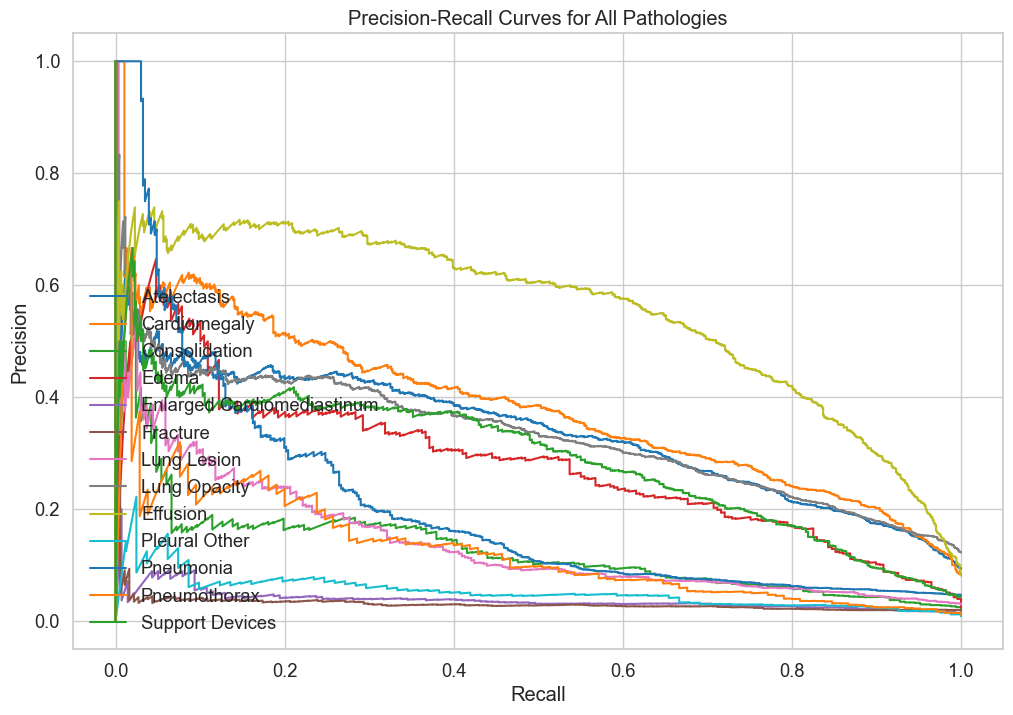


Model Performance Metrics (excluding NaN):

Atelectasis:
Accuracy: 0.8050
Precision: 0.2771
Recall: 0.6725
F1-score: 0.3925

Cardiomegaly:
Accuracy: 0.8177
Precision: 0.2786
Recall: 0.7464
F1-score: 0.4057

Consolidation:
Accuracy: 0.8432
Precision: 0.0752
Recall: 0.6747
F1-score: 0.1353

Edema:
Accuracy: 0.8979
Precision: 0.1706
Recall: 0.7948
F1-score: 0.2809

Enlarged Cardiomediastinum:
Accuracy: 0.7887
Precision: 0.0339
Recall: 0.4676
F1-score: 0.0632

Fracture:
Accuracy: 0.5647
Precision: 0.0272
Recall: 0.5924
F1-score: 0.0520

Lung Lesion:
Accuracy: 0.8066
Precision: 0.0845
Recall: 0.5609
F1-score: 0.1469

Lung Opacity:
Accuracy: 0.7552
Precision: 0.2849
Recall: 0.6589
F1-score: 0.3978

Effusion:
Accuracy: 0.8809
Precision: 0.3905
Recall: 0.8288
F1-score: 0.5309

Pleural Other:
Accuracy: 0.8276
Precision: 0.0338
Recall: 0.6667
F1-score: 0.0642

Pneumonia:
Accuracy: 0.6623
Precision: 0.0841
Recall: 0.6218
F1-score: 0.1481

Pneumothorax:
Accuracy: 0.8615
Precision: 0.0546
Recall: 

In [7]:
# 加载最佳模型进行评估
model.load_state_dict(torch.load(best_model_path))
model.eval()

all_predictions = []
all_probabilities = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        embeddings = batch['embedding'].to(device)
        labels = batch['lab'].to(device)
        outputs = model(embeddings)
        probabilities = torch.sigmoid(outputs)
        predictions = (probabilities > 0.7).float()
        all_predictions.append(predictions.cpu())
        all_probabilities.append(probabilities.cpu())
        all_labels.append(labels.cpu())

all_predictions = torch.cat(all_predictions).numpy()
all_probabilities = torch.cat(all_probabilities).numpy()
all_labels = torch.cat(all_labels).numpy()

pathologies = test_dataset.pathologies

# 评估函数
def print_confusion_matrices(predictions, labels, pathologies):
    print("\nConfusion Matrices for Each Pathology (excluding NaN):")
    for i, pathology in enumerate(pathologies):
        mask = ~np.isnan(labels[:, i])
        cm = confusion_matrix(labels[mask, i], predictions[mask, i])
        print(f"\n{pathology}:")
        print("[[True Negative, False Positive]")
        print(" [False Negative, True Positive]]")
        print(cm)

def plot_confusion_matrices(predictions, labels, pathologies):
    n_pathologies = len(pathologies)
    n_cols = 4
    n_rows = (n_pathologies + n_cols - 1) // n_cols
    plt.figure(figsize=(n_cols * 5, n_rows * 6))
    for i, pathology in enumerate(pathologies):
        mask = ~np.isnan(labels[:, i])
        cm = confusion_matrix(labels[mask, i], predictions[mask, i])
        plt.subplot(n_rows, n_cols, i + 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', cbar=False,
                    annot_kws={"size": 12}, square=True, vmin=0, vmax=np.max(cm))
        plt.title(f'Confusion Matrix: {pathology}', fontsize=12, pad=20)
        plt.ylabel('True Label', fontsize=10)
        plt.xlabel('Predicted Label', fontsize=10)
        plt.xticks([0.5, 1.5], ['0', '1'])
        plt.yticks([0.5, 1.5], ['0', '1'], rotation=0)
    plt.tight_layout()
    plt.show()

def plot_roc_curves(probabilities, labels, pathologies):
    plt.figure(figsize=(12, 8))
    for i, pathology in enumerate(pathologies):
        mask = ~np.isnan(labels[:, i])
        fpr, tpr, _ = roc_curve(labels[mask, i], probabilities[mask, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{pathology} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Pathologies')
    plt.legend(loc='lower right')
    plt.show()

def plot_pr_curves(probabilities, labels, pathologies):
    plt.figure(figsize=(12, 8))
    for i, pathology in enumerate(pathologies):
        mask = ~np.isnan(labels[:, i])
        precision, recall, _ = precision_recall_curve(labels[mask, i], probabilities[mask, i])
        plt.plot(recall, precision, label=f'{pathology}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for All Pathologies')
    plt.legend(loc='lower left')
    plt.show()

def calculate_metrics(predictions, labels, pathologies):
    metrics = {}
    for i, pathology in enumerate(pathologies):
        mask = ~np.isnan(labels[:, i])
        cm = confusion_matrix(labels[mask, i], predictions[mask, i], labels=[0, 1])
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = cm[0, 0] if cm.shape[0] > 0 else 0
            fp = cm[0, 1] if cm.shape[1] > 1 else 0
            fn = cm[1, 0] if cm.shape[0] > 1 else 0
            tp = cm[1, 1] if cm.shape[1] > 1 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        metrics[pathology] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        }
    return metrics

# 执行评估
print_confusion_matrices(all_predictions, all_labels, pathologies)
plot_confusion_matrices(all_predictions, all_labels, pathologies)
plot_roc_curves(all_probabilities, all_labels, pathologies)
plot_pr_curves(all_probabilities, all_labels, pathologies)

metrics = calculate_metrics(all_predictions, all_labels, pathologies)
print("\nModel Performance Metrics (excluding NaN):")
for pathology, metric in metrics.items():
    print(f"\n{pathology}:")
    for metric_name, value in metric.items():
        print(f"{metric_name}: {value:.4f}")

# 计算总体准确率（排除 NaN）
mask = ~np.isnan(all_labels)
overall_accuracy = (all_predictions[mask] == all_labels[mask]).mean()
print(f"\nOverall Accuracy across all pathologies (excluding NaN): {overall_accuracy:.4f}")